# Milano Dining: A User-User Network Approach
### Final Project in the Subject: Network Science

**Julia Maria Wdowinska**  
Data Science for Economics  
II year  
Master’s Degree  
Matriculation Number: 43288A

## Introduction

This project analyzes a **bipartite network** consisting of two node types: **users** and **restaurants**. In this bipartite structure, **edges connect users to restaurants they reviewed**, with no direct links among users or among restaurants.

To enable deeper analysis, the bipartite network was **projected onto a user-user network** where each node represents a user and an **undirected edge indicates shared restaurant reviews**. Edge weights correspond to the **number of commonly reviewed restaurants** between user pairs.

Nodes in the user-user network were **augmented with attributes derived from both user and restaurant data**, providing a foundation for **similarity assessment, community detection, and personalized recommendations**.

In [1]:
# Import necessary libraries
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import defaultdict, Counter
import spacy
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities
from networkx.algorithms.community.quality import modularity, partition_quality
from sklearn.metrics import normalized_mutual_info_score
from IPython.display import Image

## Dataset Description

The dataset was collected by **web scraping Yelp** using 16 keywords combined with **"Milano"** to focus on restaurants in Milan. The keywords included:

- **American**, **Bars**, **Brazilian**, **Cafes**, **Chinese**, **French**, **Indian**, **Thai**,  
- **Italian**, **Japanese**, **Mediterranean**, **Mexican**, **Middle Eastern**, **North African**,  
- **Restaurants**, **Spanish**

### Restaurant Dataset

This dataset contains **restaurant-level details** with columns such as:

- **name**: Restaurant name  
- **url**: Yelp URL acting as a **unique identifier**  
- **categories**: Restaurant categories (e.g., Chinese, Lombard)  
- **neighbourhood**: Location within Milan (e.g., Centro Storico)  
- **price_range**: Price level represented by euro signs (€)  
- **external_url** and **external_url_text**: Official website and its display text  
- **phone**: Contact number  
- **address**: Physical address  
- **working_hours**: Operating days and hours  
- **amenities**: Features like reservation acceptance or vegetarian options  
- **rating**: Average rating computed from the reviews dataset  
- **n_reviews**: Number of reviews from the reviews dataset  
- **reviews**: Concatenated and preprocessed reviews (lowercase, words only)

### Reviews Dataset

This dataset contains **individual review records** with columns:

- **url**: Used to **join with the restaurant dataset**  
- **user_id**: Unique user identifier  
- **rating**: User's rating of the restaurant  
- **review**: Review text (preprocessed as lowercase words)

## Excluded Columns

Certain columns were excluded due to **data quality issues and lack of informativeness**:

- **price_range**, **external_url**, **external_url_text**, **phone**, **address**, and **working_hours** contained many **missing or inconsistent values**.  
- **amenities** lacked discriminatory power, as most restaurants shared common values like **"takes reservations"** or **"offers takeout"**.

Rows with missing values in selected columns were removed to ensure **data completeness** for analysis.

In [2]:
# Load restaurant dataset with selected relevant columns and remove rows with missing values
df_restaurants = pd.read_csv("data/search_results1.csv")

cols = ['name', 'url', 'categories', 'neighbourhood', 'rating', 'n_reviews', 'reviews']
df_restaurants = df_restaurants[cols]

df_restaurants = df_restaurants.dropna()

df_restaurants.head()

,name,url,categories,neighbourhood,rating,n_reviews,reviews
0,Prime Burger,https://www.yelp.com/biz/prime-burger-milano?o...,Burgers,Centro Storico,4.000000,4.0,food cheeseburger friend burger burger potato ...
1,Prime Burger,https://www.yelp.com/biz/prime-burger-milano?o...,Burgers,Centro Storico,4.000000,4.0,food cheeseburger friend burger burger potato ...
2,Prime Burger,https://www.yelp.com/biz/prime-burger-milano?o...,American,Centro Storico,4.000000,4.0,food cheeseburger friend burger burger potato ...
3,Prime Burger,https://www.yelp.com/biz/prime-burger-milano?o...,American,Centro Storico,4.000000,4.0,food cheeseburger friend burger burger potato ...
4,Corey’s Soul Chicken,https://www.yelp.com/biz/coreys-soul-chicken-m...,American,Parco Sempione,4.666667,15.0,surprise visit daughter family daughter grandd...


In [3]:
# Filter reviews dataset to include only reviews for restaurants in the restaurant dataset
urls = df_restaurants['url'].unique()

df_reviews = pd.read_csv("data/reviews1.csv")

df_reviews = df_reviews[df_reviews['url'].isin(urls)]

df_reviews.head()

,url,user_id,rating,review
0,https://www.yelp.com/biz/prime-burger-milano?o...,EZKiVDXPO6jqp4vf_REOyA,5,absolutely delicious food amazing cheeseburger...
1,https://www.yelp.com/biz/prime-burger-milano?o...,lPpC5kGNSKxby6OzjhkWmA,5,yummy tomato basil burger pistachio service gr...
2,https://www.yelp.com/biz/prime-burger-milano?o...,N099kMTtP3ZRyfDyxnjzrQ,2,burger okay serve rare beware absolutely worst...
3,https://www.yelp.com/biz/prime-burger-milano?o...,pFybya3yaEV9h6CrCmJ6kw,4,service good burger good salad just onion ring...
4,https://www.yelp.com/biz/coreys-soul-chicken-m...,X8ORKtRhvTZBn3mi7HzzgQ,5,wonderful surprise come visit daughter family ...


## Creating the User-User One-Mode Network

The bipartite user-restaurant relationships were transformed into a **user-user network** by:

- Representing each user as a node  
- Connecting users with an **undirected edge if they shared at least one reviewed restaurant**  
- Assigning **edge weights** based on the **number of restaurants reviewed in common**

This network formed the basis for similarity analysis, community detection, and recommendation tasks.

In [4]:
# Group users by restaurant URL to get sets of users who reviewed each restaurant
restaurant_to_users = df_reviews.groupby('url')['user_id'].apply(set)

# Initialize an undirected graph
G = nx.Graph()

# Generate user pairs and count shared restaurants to obtain edge weights
edge_weights = defaultdict(int)
for users in restaurant_to_users:
    if len(users) < 2:
        continue
    for pair in combinations(users, 2):
        edge = tuple(sorted(pair))
        edge_weights[edge] += 1

# Add edges with weights to the graph
for (u1, u2), weight in edge_weights.items():
    G.add_edge(u1, u2, weight=weight)

In [5]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 2077
Number of edges: 53273


## Node Attributes

Node attributes were derived from both **reviews** and **restaurant** data to enrich user profiles:

### Attributes from Reviews Dataset

- **Number of unique restaurants reviewed**  
- **Average review length** (in words)  
- **Most commonly used noun**  
- **Most commonly used adjective**

### Attributes from Restaurant Dataset

- **Preferred category** among reviewed restaurants  
- **Preferred neighbourhood**  
- **Average restaurant review count** indicating popularity  
- **Preferred tag** (most common noun across restaurants reviewed)

In [6]:
# Calculate number of unique restaurants reviewed per user
n_unique_restaurants_dict = df_reviews.groupby('user_id')['url'].nunique().to_dict()

In [7]:
# Calculate average review length per user
df_reviews['review_length'] = df_reviews['review'].apply(lambda x: len(str(x).split()))
avg_review_length_dict = df_reviews.groupby('user_id')['review_length'].mean().to_dict()

In [8]:
# Extract most common noun and adjective per user from their combined reviews
nlp = spacy.load("en_core_web_sm")

def get_most_common_pos(text, pos_tag):
    doc = nlp(str(text))
    words = [token.lemma_ for token in doc if token.pos_ == pos_tag]
    if words:
        most_common_word, _ = Counter(words).most_common(1)[0]
        return most_common_word
    return None

user_reviews = df_reviews.groupby('user_id')['review'].apply(lambda texts: ' '.join(texts)).to_dict()

user_nouns_dict = {}
user_adjs_dict = {}

for user, text in user_reviews.items():
    user_nouns_dict[user] = get_most_common_pos(text, 'NOUN')
    user_adjs_dict[user] = get_most_common_pos(text, 'ADJ')

In [9]:
# Merge user data with restaurant categories and compute preferred category per user
df_user_rest_cat = df_reviews[['user_id', 'url']].merge(
    df_restaurants[['url', 'categories']].drop_duplicates(), on='url', how='left'
    ).drop('url', axis=1)

user_cat_counts = df_user_rest_cat.groupby(['user_id', 'categories']).size().reset_index(name='count')

preferred_category = user_cat_counts.loc[user_cat_counts.groupby('user_id')['count'].idxmax()]
preferred_category_dict = preferred_category.set_index('user_id')['categories'].to_dict()

In [10]:
# Merge user data with restaurant neighbourhoods and compute preferred neighbourhood per user
df_user_rest_neigh = df_reviews[['user_id', 'url']].merge(
    df_restaurants[['url', 'neighbourhood']].drop_duplicates(), on='url', how='left'
    ).drop('url', axis=1)

user_neigh_counts = df_user_rest_neigh.groupby(['user_id', 'neighbourhood']).size().reset_index(name='count')

preferred_neighbourhood = user_neigh_counts.loc[user_neigh_counts.groupby('user_id')['count'].idxmax()]
preferred_neighbourhood_dict = preferred_neighbourhood.set_index('user_id')['neighbourhood'].to_dict()

In [11]:
# Merge user data with restaurant review counts and calculate average restaurant popularity per user
df_user_rest_nreviews = df_reviews[['user_id', 'url']].merge(
    df_restaurants[['url', 'n_reviews']].drop_duplicates(), on='url', how='left')

avg_n_reviews_dict = df_user_rest_nreviews.groupby('user_id')['n_reviews'].mean().to_dict()

In [12]:
# Clean restaurant reviews by removing common words
remove_words = set([
    "food", "place", "service", "restaurant", "dish", "time", "staff",
    "menu", "price", "table", "order", "meal", "dinner", "people",
    "night", "drink", "day", "experience", "bit", "reservation"
])

def clean_text(text):
    words = str(text).split()
    filtered_words = [w for w in words if w not in remove_words]
    return " ".join(filtered_words)

df_restaurants['cleaned_reviews'] = df_restaurants['reviews'].apply(clean_text)

# Extract the most common noun (tag) from cleaned restaurant reviews
df_restaurants['tag'] = df_restaurants['cleaned_reviews'].apply(lambda text: get_most_common_pos(text, 'NOUN'))

# Merge user data with restaurant tags and calculate preferred tag per user
df_user_rest_tag = df_reviews[['user_id', 'url']].merge(
    df_restaurants[['url', 'tag']].drop_duplicates(), on='url', how='left'
).drop('url', axis=1)

user_tag_counts = df_user_rest_tag.groupby(['user_id', 'tag']).size().reset_index(name='count')

preferred_tag = user_tag_counts.loc[user_tag_counts.groupby('user_id')['count'].idxmax()]
preferred_tag_dict = preferred_tag.set_index('user_id')['tag'].to_dict()

In [13]:
# Set all computed attributes as node attributes in the graph
nx.set_node_attributes(G, n_unique_restaurants_dict, name='n_unique_restaurants')
nx.set_node_attributes(G, avg_review_length_dict, 'avg_review_length')
nx.set_node_attributes(G, user_nouns_dict, 'most_common_noun')
nx.set_node_attributes(G, user_adjs_dict, 'most_common_adjective')
nx.set_node_attributes(G, preferred_category_dict, 'preferred_category')
nx.set_node_attributes(G, preferred_neighbourhood_dict, 'preferred_neighbourhood')
nx.set_node_attributes(G, avg_n_reviews_dict, 'avg_n_reviews')
nx.set_node_attributes(G, preferred_tag_dict, 'preferred_tag')

## Graph Statistics

Key network statistics were computed to characterize the user-user graph:

- Identification of **top reviewers** by unique restaurants reviewed  
- Detection of **strongest user pairs** via edge weights  
- Computation of **degree distribution**, **average degree**, and **network density**  
- Visualization of degree distribution on a **log-log scale** to investigate **scale-free properties**

In [14]:
# Function to get top users by number of unique restaurants reviewed
def get_top_reviewers(G, n):
    return sorted(
        G.nodes(data=True),
        key=lambda x: x[1].get('n_unique_restaurants', 0),
        reverse=True
    )[:n]

# Display top 10 reviewers
top_users = get_top_reviewers(G=G, n=10)
for user_id, attrs in top_users:
    print(f"{user_id}: {attrs['n_unique_restaurants']} restaurants reviewed")

qp7pS1DwbOdd_aMa5XynKQ: 41 restaurants reviewed
Qe7dwOKdAI_J6Z4XmupOvw: 30 restaurants reviewed
QHS-71hcuw9oUM___0QXMg: 27 restaurants reviewed
5xFROQmX9j3QkPNcn5cXQA: 21 restaurants reviewed
Fr-rSVcHBq09MrvviJ1-hg: 21 restaurants reviewed
USaee7wnRAPrEQT5E2s6LQ: 19 restaurants reviewed
Ki5YTc4EeDJf5XMYbUZ_Vw: 15 restaurants reviewed
EkKaZsu_4grxwPY3PbiKBQ: 14 restaurants reviewed
HeH4pnSfdptbFCscjVZEBA: 13 restaurants reviewed
waUUfc9NhPR7ctg1co-B2Q: 13 restaurants reviewed


### Comment

The **top 10 most active users** in the dataset each reviewed **at least 10 unique restaurants**. The **most active user**, **qp7pS1DwbOdd_aMa5XynKQ**, reviewed **41 different restaurants**, followed by others with counts ranging from **13 to 30 reviews**.

In [15]:
# Function to get top edges by weight (number of shared restaurants)
def get_top_edges_by_weight(G, n):
    return sorted(
        G.edges(data=True),
        key=lambda x: x[2].get('weight', 0),
        reverse=True
    )[:n]

# Display top 10 strongest user pairs by edge weight
top_edges = get_top_edges_by_weight(G=G, n=10)
for u1, u2, attrs in top_edges:
    print(f"{u1} - {u2}: {attrs['weight']} shared restaurants")

USaee7wnRAPrEQT5E2s6LQ - Qe7dwOKdAI_J6Z4XmupOvw: 7 shared restaurants
Qe7dwOKdAI_J6Z4XmupOvw - Fr-rSVcHBq09MrvviJ1-hg: 5 shared restaurants
Qe7dwOKdAI_J6Z4XmupOvw - QHS-71hcuw9oUM___0QXMg: 5 shared restaurants
QHS-71hcuw9oUM___0QXMg - 8bViQ8HvL-uECnC-4shRsg: 5 shared restaurants
USaee7wnRAPrEQT5E2s6LQ - bQ4BeqCdAJOnBGQeWEEW4Q: 4 shared restaurants
bQ4BeqCdAJOnBGQeWEEW4Q - Qe7dwOKdAI_J6Z4XmupOvw: 4 shared restaurants
Qe7dwOKdAI_J6Z4XmupOvw - 9pBP0RUGWPOpXbYv5HuFGw: 4 shared restaurants
F5lXwAV60yA0axrJ-l0s3A - OPcBecBlM1ajsGiarkvylA: 4 shared restaurants
F5lXwAV60yA0axrJ-l0s3A - ocLjaoNRA2JtGCUWLly6ZQ: 4 shared restaurants
F5lXwAV60yA0axrJ-l0s3A - VMQlzRQYTf7htiUa6PUnug: 4 shared restaurants


### Comment

Within the **top 10 user pairs** sharing the highest number of restaurants reviewed, each pair shares **at least 4 restaurants**. The **strongest connection** is between **USaee7wnRAPrEQT5E2s6LQ** and **Qe7dwOKdAI_J6Z4XmupOvw**, who share **7 restaurants**.

Interestingly, the **most active user**, **qp7pS1DwbOdd_aMa5XynKQ**, who reviewed **41 different restaurants**, does **not appear** in any of these top pairs. This shows that even though they are very active, the restaurants they reviewed **do not overlap much with those reviewed by other active users**. This suggests their choices are either **niche** or **very varied**.

In [16]:
# Extract degree values for all nodes
degrees = [deg for _, deg in G.degree()]

# Compute basic degree statistics
avg_degree = np.mean(degrees)
std_degree = np.std(degrees)
max_degree = np.max(degrees)
min_degree = np.min(degrees)

print(f"Average degree: {avg_degree:.2f}")
print(f"Standard deviation of degree: {std_degree:.2f}")
print(f"Maximum degree: {max_degree}")
print(f"Minimum degree: {min_degree}")

Average degree: 51.30
Standard deviation of degree: 76.80
Maximum degree: 406
Minimum degree: 1


### Comment

On average, each user is connected to about **51 other users**, meaning they share at least one restaurant with around 51 users. The **minimum degree** is 1, which means some users share restaurants **with only one other user**, while the **maximum degree** is 406.

Since the **maximum number of unique restaurants reviewed by any user is 41**, which is less than both the average and maximum degrees, this shows that some restaurants are **reviewed by many users**. This suggests these restaurants are **popular** and likely **highly rated**.

In [17]:
# Identify users with maximum and minimum degrees
max_users = [user for user, deg in G.degree() if deg == max_degree]
min_users = [user for user, deg in G.degree() if deg == min_degree]

print(f"User(s) with max degree ({max_degree}): {max_users}")
print(f"User(s) with min degree ({min_degree}): {min_users}")

User(s) with max degree (406): ['5xFROQmX9j3QkPNcn5cXQA']
User(s) with min degree (1): ['W-l8Y9FnJt8zv1C7d3H5rQ', 'N2nvMlDwx21-OWKyn-tbGA', 'HHz0eZagS-yaRurd9uGa6g', 'pzBhsYV6uCtCeeixliQO0g', 'DfFR136PAWY9B6R5O4KlhA', 'nEOnqEvI14ZCQGUR87vp3Q', '_t9iWyq-yAN63JGS6EBLMg', 'q3Rc_cVUycZJJ5NcKSkpCg', 'dJf9CrQkJ5F77PbHDf1bKA', 'n_N6sqps7mtLbjFXPsP1ag', '9hUyaIANv5M8kE7ZNTAdgw', 's4PLFQuRNQpJOqQJdIkEqw', 'PdU0iAVqQ8bJUeWhkeBNYg', 'MfZEGJTJwdQiQwu9AkpIaw', '6EwtXTgaDXLKrGBrCV9p1g', '2TIWaR6KtuvyLEgBHMOClw', 'MlLPpY4Jf8J-l0fRKKh1UA', 'nCkxOedb4CQ-jVfxqQyjKQ', '7xGLhd5Vx5WEJg9MbOOIJw', 'OEEecY20Wtb7KEKUlx6bNA', 'N5K90NIvrQ2mJ7n912GDDQ', 'CmlBfx0HeQBQQQpL2H6vPA', 'HdQOIypICL6_oV_5l6eHaw', 'wq-tdppLhdSMxDEfuZ9VUQ', 'U_OJI-OF0HCE6RMNkI9HtQ', 'So4JWyU1vJE_5XB-t4u8xQ', 'n5LqT6N7B8Yq9acPz_hHiA', 'Ujx5by4ViOdhW_kmZEoFlQ', 'bSiwlUEK14XFbPofZa1m1Q', 'Mdwk91Sh83rNikqNayEeTQ', 'Rxz5ZnIy9D5fJhm725VGig', '6fkS9cEAGkt6YiSnfEK8lw', 'LGbHveg3H8fAP5dZrRWsQA', 'I_IfyIhPZqS3ElL55nPfrA', '435I56jyTf2UlGCfr2yygg', 'k

In [18]:
# Compute network density
density = nx.density(G)
print(f"Network density: {density:.6f}")

Network density: 0.024710


### Comment

The **network density of 0.0247** means that only about **2.47% of all possible user-to-user connections exist**. This indicates that the network is **sparse** - most users do not share restaurants with many others but tend to **share more restaurants within smaller groups**. This pattern suggests the presence of **communities** where users with **similar tastes** have more overlap in the restaurants they review.

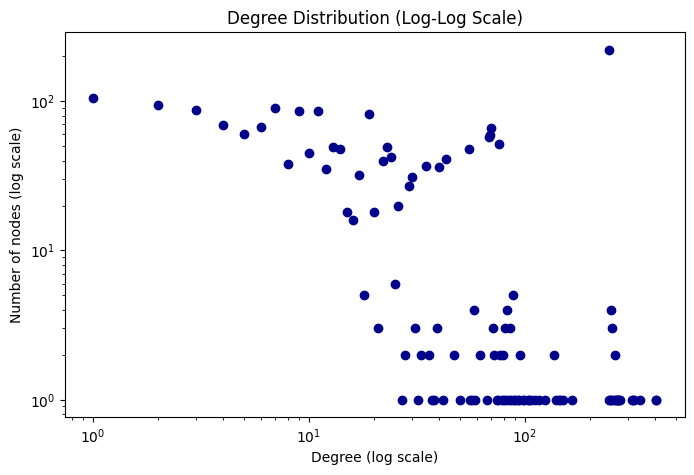

In [19]:
# Count number of nodes per degree
degree_counts = Counter(degrees)

# Sort degrees and counts for plotting
deg, counts = zip(*sorted(degree_counts.items()))

# Plot degree distribution on log-log scale
plt.figure(figsize=(8,5))
plt.loglog(deg, counts, marker='o', linestyle='none', color='darkblue')
plt.xlabel('Degree (log scale)')
plt.ylabel('Number of nodes (log scale)')
plt.title('Degree Distribution (Log-Log Scale)')
plt.show()

### Comment

The **degree distribution plot** shows **many nodes with low degree** and **few nodes with very high degree (hubs)**. This pattern is typical of **real-world networks**, which are often **scale-free** - meaning there is **no single characteristic degree** that defines the network. This property will be further explored when comparing the network to an **Erdos-Renyi random network**.

## Connected Components and Clustering

Network structure was further explored through:

- The **number and size distribution of connected components**, revealing fragmentation  
- Identification of the **largest connected component (LCC)** as the network core  
- Calculation of the **average local clustering coefficient** and **global clustering coefficient (transitivity)** to measure cohesiveness  
- Analysis of **local bridges** and **bridges**, indicating critical network connections

This helped assess the network’s robustness and cohesiveness.

In [20]:
# Get all connected components
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")

Number of connected components: 61


### Comment

The graph contains **61 connected components**, which confirms that it is **disconnected** - **not every user can reach every other user through a path**. This indicates the presence of **isolated clusters of users**, meaning some groups share restaurants only **within their own component** and **not with the broader network**.

In [21]:
# Calculate sizes of each connected component
component_sizes = [len(c) for c in components]

# Compute and display statistics for component sizes
print(f"Mean component size: {np.mean(component_sizes):.2f}")
print(f"Std component size: {np.std(component_sizes):.2f}")
print(f"Max component size: {np.max(component_sizes)}")
print(f"Min component size: {np.min(component_sizes)}")

Mean component size: 34.05
Std component size: 238.97
Max component size: 1885
Min component size: 2


### Comment

On average, a **connected component** includes about **34 users**, but the **distribution is highly skewed**. The **largest component** contains **1885 users**, while the **smallest** has just **2**.

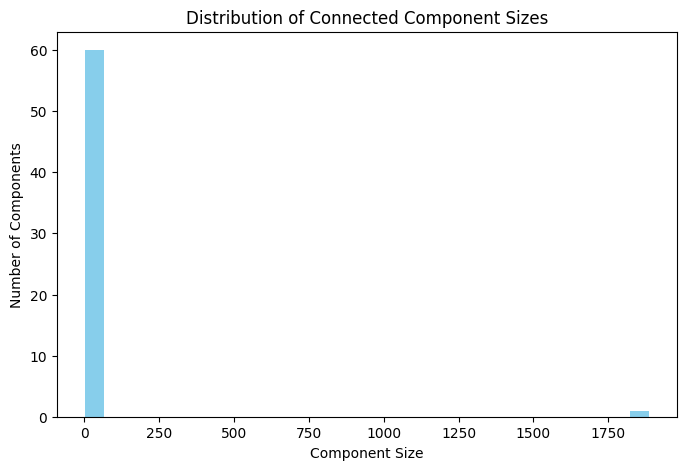

In [22]:
# Visualize distribution of connected component sizes
plt.figure(figsize=(8,5))
plt.hist(component_sizes, bins=30, color='skyblue')
plt.xlabel('Component Size')
plt.ylabel('Number of Components')
plt.title('Distribution of Connected Component Sizes')
plt.show()

In [23]:
# Identify largest connected component (LCC)
largest_cc = max(components, key=len)
print(f"Largest connected component size: {len(largest_cc)}")

# Proportion of nodes in LCC
print(f"Proportion of nodes in LCC: {len(largest_cc) / G.number_of_nodes():.4f}")

Largest connected component size: 1885
Proportion of nodes in LCC: 0.9076


### Comment

The **largest connected component (LCC)** contains **1885 users**, which is about **91%** of all users in the network. The remaining **9%** are spread across **60 smaller disconnected components**. This pattern is **typical in real-world networks**, where the **majority of users are indirectly connected**, often through only a few intermediaries.

In [24]:
# Calculate average local clustering coefficient
clustering_avg = nx.average_clustering(G)
print(f"Average local clustering coefficient: {clustering_avg:.4f}")

Average local clustering coefficient: 0.9064


### Comment

The **average local clustering coefficient** of **0.9064** means that, on average, **91% of a user's neighbors are also connected to each other**. This indicates a **high level of local interconnectedness**, which is very common in **social networks**. In this case, it suggests that if **user A shares a restaurant with user B**, and **user B shares a restaurant with user C**, then it is very likely that **user A also shares a restaurant with user C**. This reflects how users might be influenced by mutual connections, such as **trying and reviewing restaurants recommended by others** in their network.

In [25]:
# Define a function to check if an edge is a local bridge (no common neighbors)
def is_local_bridge(G, u, v):
    return len(set(G[u]).intersection(G[v])) == 0

# Identify all local bridges in the graph
local_bridges = [(u, v) for u, v in G.edges() if is_local_bridge(G, u, v)]
print(f"Number of local bridges: {len(local_bridges)}")
print("Example local bridges:", local_bridges[:5])

Number of local bridges: 83
Example local bridges: [('W-l8Y9FnJt8zv1C7d3H5rQ', 'wwzQBYyPTupm2GoDWEPq3A'), ('K7Sc_XwxFKJzCU4WD8ndkQ', 'Uk9m0r2AZdLwxMf63YC6jQ'), ('K7Sc_XwxFKJzCU4WD8ndkQ', 'oBDMb1hVnlQSCZK0f6W7FQ'), ('Uk9m0r2AZdLwxMf63YC6jQ', 'Z3y3_yvITL4eJLCxBFU7pw'), ('kY7guT7tX1oLrekG5fTagw', 'a2LKMqwwBRFKxxrGUFZM6A')]


### Comment

There are **83 local bridges** in the network. A **local bridge** is a connection between **two users who do not share any common neighbors**, and **removing this connection increases their distance to more than two steps**. These bridges are **important for spreading new information**, as they **link otherwise distant parts of the network**.

In [26]:
# Calculate global clustering coefficient (transitivity)
clustering_global = nx.transitivity(G)
print(f"Global clustering coefficient (transitivity): {clustering_global:.4f}")

Global clustering coefficient (transitivity): 0.9517


### Comment

The **global clustering coefficient** (also called **transitivity**) of **0.9517** means that about **95% of all triplets** in the network are **closed**, i.e., if two users are both connected to a third user, they are also likely connected to each other. This shows that the network is **highly transitive not only locally but also globally**.

This result is **somewhat unexpected**, because in many real-world networks, **low-degree nodes** tend to have **high clustering**, while **high-degree nodes (hubs)** tend to have **low clustering**, which usually leads to **high average local clustering** but **low global clustering**. In this case, the very **high global clustering** suggests that even **high-degree users** tend to be embedded in **tightly connected groups**.

In [27]:
# Identify all bridges (edges which increase components if removed)
bridges = list(nx.bridges(G))
print(f"Number of bridges: {len(bridges)}")
print("Example bridges:", bridges[:5])

Number of bridges: 76
Example bridges: [('W-l8Y9FnJt8zv1C7d3H5rQ', 'wwzQBYyPTupm2GoDWEPq3A'), ('Uk9m0r2AZdLwxMf63YC6jQ', 'Z3y3_yvITL4eJLCxBFU7pw'), ('kY7guT7tX1oLrekG5fTagw', 'a2LKMqwwBRFKxxrGUFZM6A'), ('bQ4BeqCdAJOnBGQeWEEW4Q', '6EwtXTgaDXLKrGBrCV9p1g'), ('bQ4BeqCdAJOnBGQeWEEW4Q', 'pEvhyxL7YAGrYsKB29VJvg')]


### Comment

There are **76 bridges** in the network. A **bridge** is a connection that, if removed, would **increase the number of connected components**, effectively **disconnecting part of the network**. These bridges are crucial because they **link otherwise disconnected user groups**.

This implies that **some users act as connectors** between communities that might prefer different **neighbourhoods, cuisines, or restaurant types**. Without these bridges, users with different preferences would remain **isolated**, and **information or influence** (e.g., restaurant recommendations) would be **less likely to spread across the whole network**.

## Comparison with Erdos-Renyi Random Network

An **Erdos-Renyi (ER) random network** with the same node count and edge density was generated for baseline comparison.

Metrics compared included:

- Number of nodes and edges  
- Average degree  
- Number of connected components  
- Average local clustering coefficient  
- Global clustering coefficient (transitivity)

Both networks were visualized side-by-side with a spring layout. Degree distributions were compared using the **Empirical Complementary Cumulative Distribution Function (ECCDF)** on a log-log scale to detect heavy-tailed or scale-free patterns absent in the ER model.

In [28]:
# Generate an Erdos-Renyi random network with same number of nodes and approximate density
G_er = nx.erdos_renyi_graph(n=G.number_of_nodes(), p=density, seed=42)

In [29]:
# Compare number of nodes and edges
print(f"Yelp network - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"ER network - Nodes: {G_er.number_of_nodes()}, Edges: {G_er.number_of_edges()}")

Yelp network - Nodes: 2077, Edges: 53273
ER network - Nodes: 2077, Edges: 53320


### Comment

Both the **Yelp network** and the **Erdos-Renyi (ER) network** have **2077 nodes**, ensuring a **fair comparison**. The **number of edges** is also similar - 53,273 in Yelp and 53,320 in ER - because the **connection probability** ***p*** in the ER model was set to match the **density of the original Yelp network**.

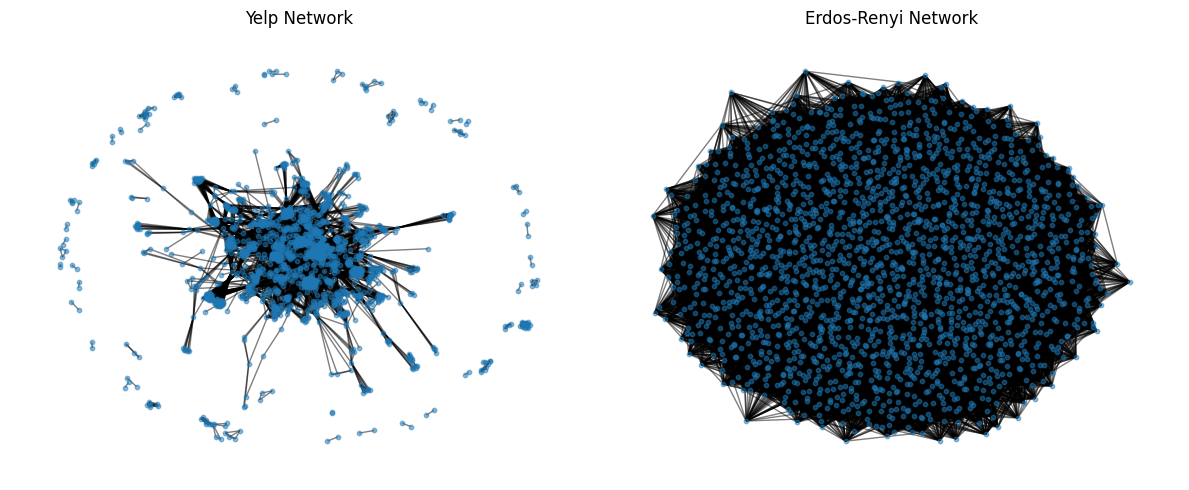

In [30]:
# Visual comparison of network structure
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
nx.draw_spring(G, node_size=10, alpha=0.5)
plt.title("Yelp Network")

plt.subplot(1, 2, 2)
nx.draw_spring(G_er, node_size=10, alpha=0.5)
plt.title("Erdos-Renyi Network")

plt.tight_layout()
plt.show()

### Comment

The **Yelp network** shows a clear **community structure**, where users form **groups** based on shared restaurant reviews. Some users act as **hubs**, connecting many others, which creates an **uneven pattern of connectivity**.

In contrast, the **Erdos-Renyi (ER) network** looks more **uniform and random**. Connections are spread more evenly, and there are **no clear groups or highly connected users**. This reflects the random nature of ER networks, which **do not mimic real social behavior**.

In [31]:
# Compare average degree
degrees_ER = [deg for _, deg in G_er.degree()]
avg_deg_ER = np.mean(degrees_ER)

print(f"Average degree - Yelp: {avg_degree:.2f}, ER: {avg_deg_ER:.2f}")

Average degree - Yelp: 51.30, ER: 51.34


### Comment

The **average degree** is nearly the same in both networks - **51.30 for Yelp** and **51.34 for ER** - which is expected since the ER network’s connection probability was set to **match the Yelp network’s density**. This allows for a **fair comparison** of other network properties.

In [32]:
# Compare number of connected components
comp_ER = nx.number_connected_components(G_er)

print(f"Number of connected components - Yelp: {len(components)}, ER: {comp_ER}")

Number of connected components - Yelp: 61, ER: 1


### Comment

In the ER network, there is only **one giant connected component**, meaning the network is **fully connected**. This happens because the **average degree (51.34)** is much higher than the threshold of **ln(number of nodes) = 7.64**. Having passed this point, the network moves **beyond the supercritical phase**, where a giant component forms, into the **connected phase** in which the **entire network becomes connected**.

In [33]:
# Compare average local clustering coefficient
clust_ER = nx.average_clustering(G_er)

print(f"Average local clustering coefficient - Yelp: {clustering_avg:.4f}, ER: {clust_ER:.4f}")

Average local clustering coefficient - Yelp: 0.9064, ER: 0.0248


In [34]:
# Compare global clustering coefficient (transitivity)
trans_ER = nx.transitivity(G_er)

print(f"Global clustering coefficient - Yelp: {clustering_global:.4f}, ER: {trans_ER:.4f}")

Global clustering coefficient - Yelp: 0.9517, ER: 0.0248


### Comment

Both the **average local** and **global clustering coefficients** in the **ER network** are very **low (0.0248)** compared to those in the **Yelp network** (**0.9064** and **0.9517**, respectively). This is expected, as the **ER network is random**, and edges are placed **without regard to neighborhood structure**, making the formation of tightly knit groups of users much less likely.

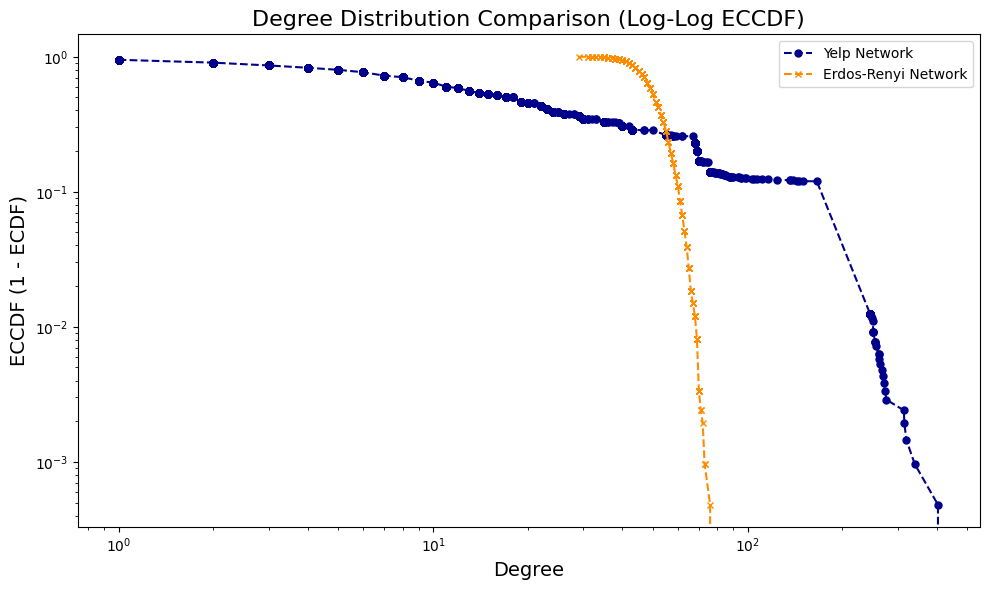

In [35]:
# Compute ECDFs
ecdf_real = ECDF(degrees)
x_real = np.sort(degrees)
y_real = 1 - ecdf_real(x_real)

ecdf_random = ECDF(degrees_ER)
x_random = np.sort(degrees_ER)
y_random = 1 - ecdf_random(x_random)

# Plot ECCDFs
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')

plt.loglog(x_real, y_real, marker='o', ms=5, linestyle='--', color='darkblue', label='Yelp Network')
plt.loglog(x_random, y_random, marker='x', ms=5, linestyle='--', color='darkorange', label='Erdos-Renyi Network')

plt.xlabel('Degree', fontsize=14)
plt.ylabel('ECCDF (1 - ECDF)', fontsize=14)
plt.title('Degree Distribution Comparison (Log-Log ECCDF)', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

### Comment

The plot shows the **Empirical Complementary Cumulative Distribution Function (ECCDF)** on a **log-log scale** for both the **Yelp** and **ER networks**. The line for the **ER network** is **narrow and decays quickly**, consistent with a **Poisson degree distribution** (which arises when *N* is large and *p* is small). This means that **most nodes have degrees close to the average**, and there are **few extreme values**.

In contrast, the line for the **Yelp network** decays **much more slowly**, indicating a **long-tailed distribution**: **many nodes with low degree** and **a few hubs with very high degree**. This pattern is characteristic of a **power-law distribution**, which is **typical of real-world networks**, especially social networks, where **preferential attachment** and **local clustering** occur.

## Centrality Measures

Multiple centrality metrics quantified node importance:

- **Degree centrality**: Number of neighbours  
- **Weighted degree centrality**: Sum of connected edge weights  
- **Betweenness centrality**: Frequency on shortest paths  
- **Closeness centrality**: Average distance to other nodes

The **top 10 hubs** per metric were identified, and correlations among centrality measures were examined.

In [36]:
# Degree centrality
top_hubs_degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 hubs by degree:")
for user, deg in top_hubs_degree:
    print(f"{user}: {deg} connections")

Top 10 hubs by degree:
5xFROQmX9j3QkPNcn5cXQA: 406 connections
QHS-71hcuw9oUM___0QXMg: 403 connections
waUUfc9NhPR7ctg1co-B2Q: 340 connections
Hb_zcUrrF4LoH6aDnhYUqQ: 320 connections
tvgUrKRRXqO8A9Gl6hLhiw: 315 connections
GpTR4aYNMrs95B9y2NC9Cg: 314 connections
O-e0RZZAag2gU9NPDahSFA: 276 connections
xnfNL_K-PtRNQ5GA44IbTQ: 274 connections
MGrNMMePj0kw-6LIL1SflQ: 271 connections
Qe7dwOKdAI_J6Z4XmupOvw: 269 connections


### Comment

**Degree centrality** identifies nodes with the **highest number of direct connections** as the **most central**. In the **Yelp network**, these top users have **rated restaurants shared with hundreds of others**, making them the most connected individuals.

This could indicate that they **visit popular restaurants**, which many others also review. Alternatively, it might suggest that **their reviews have influenced other users** to try the same places, reinforcing their central role in the network.

In [37]:
# Weighted degree centrality
weighted_degree = dict(G.degree(weight='weight'))
top_hubs_weighted = sorted(weighted_degree.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 hubs by weighted degree:")
for user, wdeg in top_hubs_weighted:
    print(f"{user}: {wdeg} total shared restaurants")

Top 10 hubs by weighted degree:
waUUfc9NhPR7ctg1co-B2Q: 565 total shared restaurants
Hb_zcUrrF4LoH6aDnhYUqQ: 559 total shared restaurants
MGrNMMePj0kw-6LIL1SflQ: 509 total shared restaurants
8cpbi9lmxRstKBUdqv8DXg: 501 total shared restaurants
eh7D7I020KYbp7KutrfN4g: 492 total shared restaurants
RaKPxD4Kt9-WwES7PmM1QA: 483 total shared restaurants
sm_kcm_SvAPOCRc_UXbmYA: 483 total shared restaurants
ctHImYWJLYkAQ9NkQhQQjQ: 483 total shared restaurants
5EWd08XypbNkK0EVmwCOYg: 483 total shared restaurants
UEQ0Ljd1uLj0RmTvcC0YTQ: 483 total shared restaurants


### Comment

**Weighted degree centrality** measures the **total strength of a node’s connections** by summing the edge weights - in this case, the **total number of restaurants shared with others**. Unlike standard degree centrality, which only counts the number of connections, weighted degree reflects **how intensely users are connected**.

This highlights users who consistently review **many of the same restaurants as others**, suggesting **stronger ties** and potentially **greater influence** in shaping others' restaurant choices.

Interestingly, the **top user by degree centrality** (**5xFROQmX9j3QkPNcn5cXQA**) does **not appear** in the top 10 by weighted degree. This means that although this user connects with many others, they **share relatively few restaurants with each individual**, possibly due to a **diverse or niche set of restaurants** that are not widely reviewed by others.

In [38]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(G)
top_hubs_bet = sorted(bet_cen.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 hubs by betweenness centrality:")
for user, bc in top_hubs_bet:
    print(f"{user}: {bc:.4f}")

Top 10 hubs by betweenness centrality:
Qe7dwOKdAI_J6Z4XmupOvw: 0.1309
QHS-71hcuw9oUM___0QXMg: 0.1178
USaee7wnRAPrEQT5E2s6LQ: 0.1049
5xFROQmX9j3QkPNcn5cXQA: 0.0957
waUUfc9NhPR7ctg1co-B2Q: 0.0529
IpGHTfyb5HnrxlcpmrFtrg: 0.0466
Ki5YTc4EeDJf5XMYbUZ_Vw: 0.0456
EkKaZsu_4grxwPY3PbiKBQ: 0.0447
Fr-rSVcHBq09MrvviJ1-hg: 0.0342
JBzjZftAASrvGLKCU1r7KQ: 0.0290


## Comment

**Betweenness centrality** measures **how often a node lies on the shortest path between pairs of nodes**, capturing its potential to **mediate communication** or **serve as a bridge** between different parts of the network.

The node with the **highest betweenness centrality** is **Qe7dwOKdAI_J6Z4XmupOvw**, even though it ranked only **10th in degree centrality**. This suggests that while it may not be the most connected, it **plays a crucial role in linking otherwise distant users** - likely acting as a **connector between clusters or communities**.

In [39]:
# Closeness centrality
closeness = nx.closeness_centrality(G)
top_hubs_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 hubs by closeness centrality:")
for user, score in top_hubs_closeness:
    print(f"{user}: {score:.4f}")

Top 10 hubs by closeness centrality:
5xFROQmX9j3QkPNcn5cXQA: 0.4503
QHS-71hcuw9oUM___0QXMg: 0.4425
USaee7wnRAPrEQT5E2s6LQ: 0.4421
Qe7dwOKdAI_J6Z4XmupOvw: 0.4363
Hb_zcUrrF4LoH6aDnhYUqQ: 0.4203
waUUfc9NhPR7ctg1co-B2Q: 0.4196
O-e0RZZAag2gU9NPDahSFA: 0.3962
Ki5YTc4EeDJf5XMYbUZ_Vw: 0.3948
EkKaZsu_4grxwPY3PbiKBQ: 0.3916
nxqn4x2eSXJtqgQeiIRL2g: 0.3886


## Comment

**Closeness centrality** measures **how close a node is to all other nodes in the network**, i.e., how quickly it can reach other nodes through **shortest paths**. A node with high closeness centrality can **efficiently spread information** or influence across the network.

This measure is not well-defined for a **disconnected graph**, since **path lengths to unreachable nodes are infinite**. However, **NetworkX handles this** by computing closeness centrality for each node **only within its own connected component**.

In this case, the **largest connected component includes about 91% of all nodes**, so the top-ranked nodes are likely from this component. Therefore, **closeness centrality rankings are meaningful and comparable** among these top users, as they reflect their centrality **within the dominant structure of the network**.

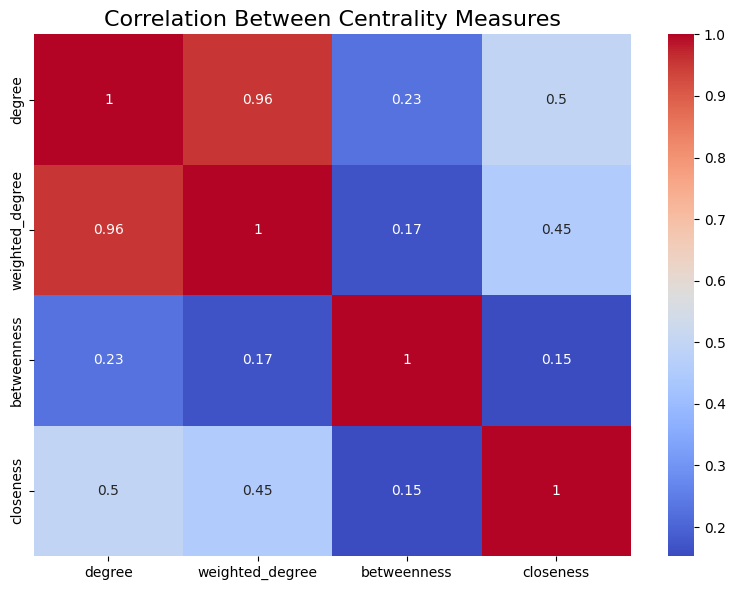

In [40]:
# Correlation matrix of centrality measures
centrality_df = pd.DataFrame({
    'degree': dict(G.degree()).values(),
    'weighted_degree': weighted_degree.values(),
    'betweenness': bet_cen.values(),
    'closeness': closeness.values()
}, index=G.nodes())

corr_matrix = centrality_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", cbar=True)

plt.title("Correlation Between Centrality Measures", fontsize=16)
plt.tight_layout()
plt.show()

## Comment

A **correlation matrix** helps reveal how different **centrality measures** relate to one another.

In the case of the **Yelp network**, the following patterns are observed:

- There is a **very high correlation** between **degree** and **weighted degree centrality**. This means that **users who have many connections** also tend to have **stronger connections**, i.e., they share many restaurants with others.

- There is **moderate correlation** between **degree/weighted degree** and **closeness centrality**, indicating that **more connected users** tend to **be able to reach others faster**, but the relationship is not perfect.

- There is **low correlation** between **degree/weighted degree** and **betweenness centrality**, suggesting that **being popular or strongly connected** does not necessarily mean **acting as a bridge between others**.

- Similarly, **betweenness** and **closeness centrality** show low correlation, highlighting that **users who lie on many shortest paths** (brokers) are not always **the ones with shortest average path lengths to others**.

## Assortativity Coefficients

Assortativity coefficients measured tendency of users to connect based on attribute similarity:

- **Numeric assortativity** for continuous attributes (unique restaurants, review length, number of reviews)  
- **Categorical assortativity** for discrete attributes (common noun/adjective, preferred category/neighbourhood/tag)

Higher values indicate homophily in the network.

In [41]:
print("Numeric assortativity:")
for attr in ['n_unique_restaurants', 'avg_review_length', 'avg_n_reviews']:
    r = nx.numeric_assortativity_coefficient(G, attr)
    print(f"  {attr}: {r:.4f}")

Numeric assortativity:
  n_unique_restaurants: 0.0213
  avg_review_length: 0.0016
  avg_n_reviews: 0.8375


In [42]:
print("Categorical assortativity:")
for attr in ['most_common_noun', 'most_common_adjective', 'preferred_category',
             'preferred_neighbourhood', 'preferred_tag']:
    r = nx.attribute_assortativity_coefficient(G, attr)
    print(f"  {attr}: {r:.4f}")

Categorical assortativity:
  most_common_noun: 0.0127
  most_common_adjective: 0.0033
  preferred_category: 0.7980
  preferred_neighbourhood: 0.8118
  preferred_tag: 0.7976


## Comment

**High assortativity values** for attributes such as **avg_n_reviews**, **preferred_category**, **preferred_neighbourhood**, and **preferred_tag**, alongside **low values** for **n_unique_restaurants**, **most_common_noun**, and **most_common_adjective**, suggest that users tend to connect **not because of how they write their reviews** (e.g., average length, commonly used words), but because of **shared preferences in the types of restaurants** they visit and review.

In particular, **users are more likely to be connected** if they review **restaurants that are similarly popular, belong to the same category, are located in the same neighbourhood, or have similar tags**. This supports the existence of a **preference-based community structure**, where users cluster around **shared tastes and habits** rather than stylistic writing similarities.

## Community Detection Methods

Three community detection algorithms were applied:

1. **Louvain method** optimizing modularity  
2. **Greedy modularity maximization**  
3. **Label propagation**

Analyses included:

- Number of communities detected  
- Community size statistics  
- Modularity, coverage, and performance metrics  
- Similarity between partitions via Normalized Mutual Information (NMI)

In [43]:
# Louvain partition and modularity
louvain_partition = community_louvain.best_partition(G, random_state=42)
louvain_mod = community_louvain.modularity(louvain_partition, G)

# Louvain on random graph
louvain_partition_ER = community_louvain.best_partition(G_er, random_state=42)
louvain_mod_ER = community_louvain.modularity(louvain_partition_ER, G_er)

print(f"Modularity (Yelp): {louvain_mod:.4f}")
print(f"Modularity (ER): {louvain_mod_ER:.4f}")

Modularity (Yelp): 0.5446
Modularity (ER): 0.1212


## Comment

The **modularity score** for the **Yelp network** is **0.5447**, indicating a **strong community structure**. This means that users tend to form **tightly connected groups**, likely based on shared restaurant preferences, locations, or behaviours. In contrast, the **ER network** has a much lower modularity of **0.1212**, which is expected since **edges are placed randomly** and there is **no inherent structure**.

In [44]:
louvain_n_communities = len(set(louvain_partition.values()))
print(f"Number of communities (Louvain): {louvain_n_communities}")

Number of communities (Louvain): 78


In [45]:
louvain_community_sizes = Counter(louvain_partition.values())

louvain_sizes = np.array(list(louvain_community_sizes.values()))
print(f"Community sizes stats (Louvain):\n"
      f"Average: {louvain_sizes.mean():.2f}\n"
      f"Std dev: {louvain_sizes.std():.2f}\n"
      f"Min: {louvain_sizes.min()}\n"
      f"Max: {louvain_sizes.max()}")

Community sizes stats (Louvain):
Average: 26.63
Std dev: 70.60
Min: 2
Max: 441


In [46]:
# Greedy modularity communities
greedy_communities = list(greedy_modularity_communities(G))

greedy_partition = {
    node: i
    for i, community in enumerate(greedy_communities)
    for node in community
}

greedy_n_communities = len(set(greedy_partition.values()))
print(f"Number of communities (Greedy Modularity): {greedy_n_communities}")

Number of communities (Greedy Modularity): 78


In [47]:
greedy_community_sizes = Counter(greedy_partition.values())

greedy_sizes = np.array(list(greedy_community_sizes.values()))
print(f"Community sizes stats (Greedy Modularity):\n"
      f"Average: {greedy_sizes.mean():.2f}\n"
      f"Std dev: {greedy_sizes.std():.2f}\n"
      f"Min: {greedy_sizes.min()}\n"
      f"Max: {greedy_sizes.max()}")

Community sizes stats (Greedy Modularity):
Average: 26.63
Std dev: 84.42
Min: 2
Max: 648


In [48]:
label_communities = list(label_propagation_communities(G))

label_partition = {
    node: i
    for i, community in enumerate(label_communities)
    for node in community
}

label_n_communities = len(set(label_partition.values()))
print(f"Number of communities (Label Propagation): {label_n_communities}")

Number of communities (Label Propagation): 177


In [49]:
label_community_sizes = Counter(label_partition.values())

label_sizes = np.array(list(label_community_sizes.values()))
print(f"Community sizes stats (Label Propagation):\n"
      f"Average: {label_sizes.mean():.2f}\n"
      f"Std dev: {label_sizes.std():.2f}\n"
      f"Min: {label_sizes.min()}\n"
      f"Max: {label_sizes.max()}")

Community sizes stats (Label Propagation):
Average: 11.73
Std dev: 40.06
Min: 2
Max: 483


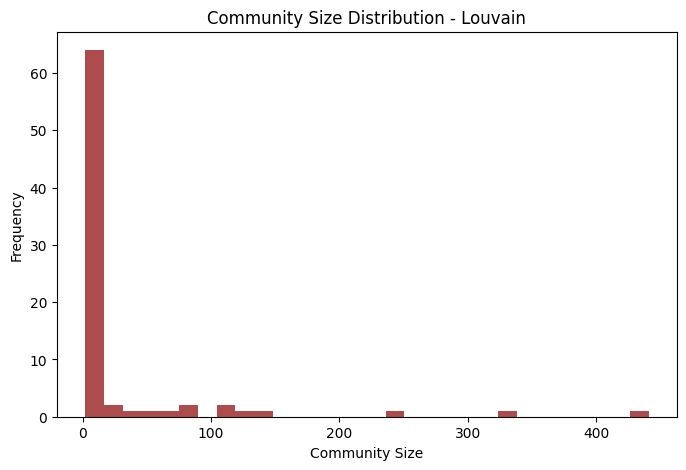

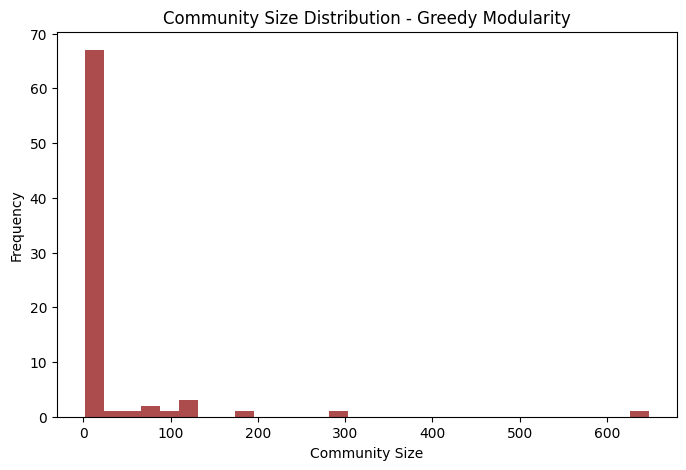

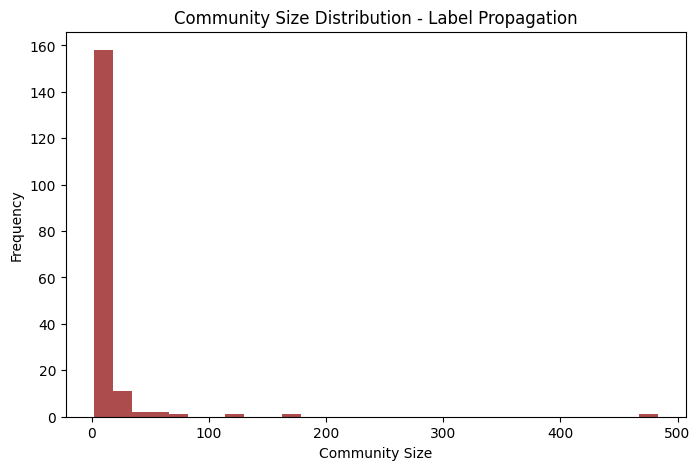

In [50]:
def plot_comm_sizes(community_sizes, algorithm):
    sizes = list(community_sizes.values())
    plt.figure(figsize=(8,5))
    plt.hist(sizes, bins=30, color='darkred', alpha=0.7)
    plt.title(f"Community Size Distribution - {algorithm}")
    plt.xlabel("Community Size")
    plt.ylabel("Frequency")
    plt.show() 


# Plotting community size distributions for all three algorithms
plot_comm_sizes(louvain_community_sizes, "Louvain")
plot_comm_sizes(greedy_community_sizes, "Greedy Modularity")
plot_comm_sizes(label_community_sizes, "Label Propagation")

## Comment

Three community detection methods were applied: **Louvain**, **Greedy modularity maximization**, and **Label propagation**. The Louvain and Greedy methods both detected **78 communities**, while Label propagation found **176**. In all three cases, **most communities are small**, but the **largest community sizes** vary:

- **Louvain**: 418 users

- **Greedy**: 648 users

- **Label propagation**: 483 users

The **smallest communities** in each method have just **2 users**.

In [51]:
def partition_to_communities(partition):
    communities = {}
    for node, comm_id in partition.items():
        communities.setdefault(comm_id, set()).add(node)
    return list(communities.values())

louvain_communities = partition_to_communities(louvain_partition)

print("Louvain:")
print("Modularity:", modularity(G, louvain_communities))
print("Coverage:", partition_quality(G, louvain_communities)[0])
print("Performance:", partition_quality(G, louvain_communities)[1])

Louvain:
Modularity: 0.5446487053664771
Coverage: 0.9407579824676665
Performance: 0.919268564876531


In [52]:
print("Greedy Modularity:")
print("Modularity:", modularity(G, greedy_communities))
print("Coverage:", partition_quality(G, greedy_communities)[0])
print("Performance:", partition_quality(G, greedy_communities)[1])

Greedy Modularity:
Modularity: 0.5136656080666022
Coverage: 0.8969083776021625
Performance: 0.8783348779132494


In [53]:
print("Label Propagation:")
print("Modularity:", modularity(G, label_communities))
print("Coverage:", partition_quality(G, label_communities)[0])
print("Performance:", partition_quality(G, label_communities)[1])

Label Propagation:
Modularity: 0.4432892782601134
Coverage: 0.9498244889531282
Performance: 0.9511792148710113


## Comment

To choose between the three partitions, **modularity**, **coverage**, and **performance** were computed.

The **Louvain method** achieved the **highest modularity** (0.545), indicating **the strongest community structure** according to this measure. It also showed **high coverage** (0.94) and **performance** (0.93), meaning that **most edges fall within communities** and that **node pairs are well classified as connected or not within communities**.

The **Greedy modularity maximization method** had slightly **lower modularity** (0.51), **coverage** (0.90), and **performance** (0.88), suggesting a **somewhat weaker** but still meaningful **community structure**.

The **Label propagation method** yielded the **lowest modularity** (0.44) but the **highest coverage** (0.95) and **performance** (0.95), reflecting a large proportion of edges within communities and good classification, though its **community structure is less modular**.

Overall, the **Louvain method provides the best balance between modularity and classification metrics**, making it the **preferred choice** for community detection in this network.

In [54]:
nodes = list(G.nodes())

louvain_labels = [louvain_partition[node] for node in nodes]
greedy_labels = [greedy_partition[node] for node in nodes]
label_labels = [label_partition[node] for node in nodes]

nmi_louvain_greedy = normalized_mutual_info_score(louvain_labels, greedy_labels)
nmi_louvain_label = normalized_mutual_info_score(louvain_labels, label_labels)
nmi_greedy_label = normalized_mutual_info_score(greedy_labels, label_labels)

print(f"NMI Louvain vs Greedy: {nmi_louvain_greedy:.4f}")
print(f"NMI Louvain vs Label Propagation: {nmi_louvain_label:.4f}")
print(f"NMI Greedy vs Label Propagation: {nmi_greedy_label:.4f}")

NMI Louvain vs Greedy: 0.7379
NMI Louvain vs Label Propagation: 0.6899
NMI Greedy vs Label Propagation: 0.6578


## Comment

To see **how different the detected communities are**, the communities identified by the three algorithms were assigned to users, and the **Normalized Mutual Information (NMI)** was computed.

The results show a **relatively high similarity** between the community partitions, **especially between Louvain and Greedy** (NMI = 0.735), followed by Louvain and Label Propagation (0.692), and Greedy and Label Propagation (0.658). This means that **choosing the results of the Louvain method over the others is reasonable**, as it yields a community structure similar to the alternatives, while offering the highest modularity and a good balance between coverage and performance.

In [55]:
# Assign Louvain community labels as node attributes
nx.set_node_attributes(G, louvain_partition, 'community')

In [56]:
# Replace None values in node attributes with 'unknown'
for n, attrs in G.nodes(data=True):
    for k, v in list(attrs.items()):
        if v is None:
            G.nodes[n][k] = "unknown"

# Save the graph for visualization
nx.write_gexf(G, "graphs/yelp_network.gexf")

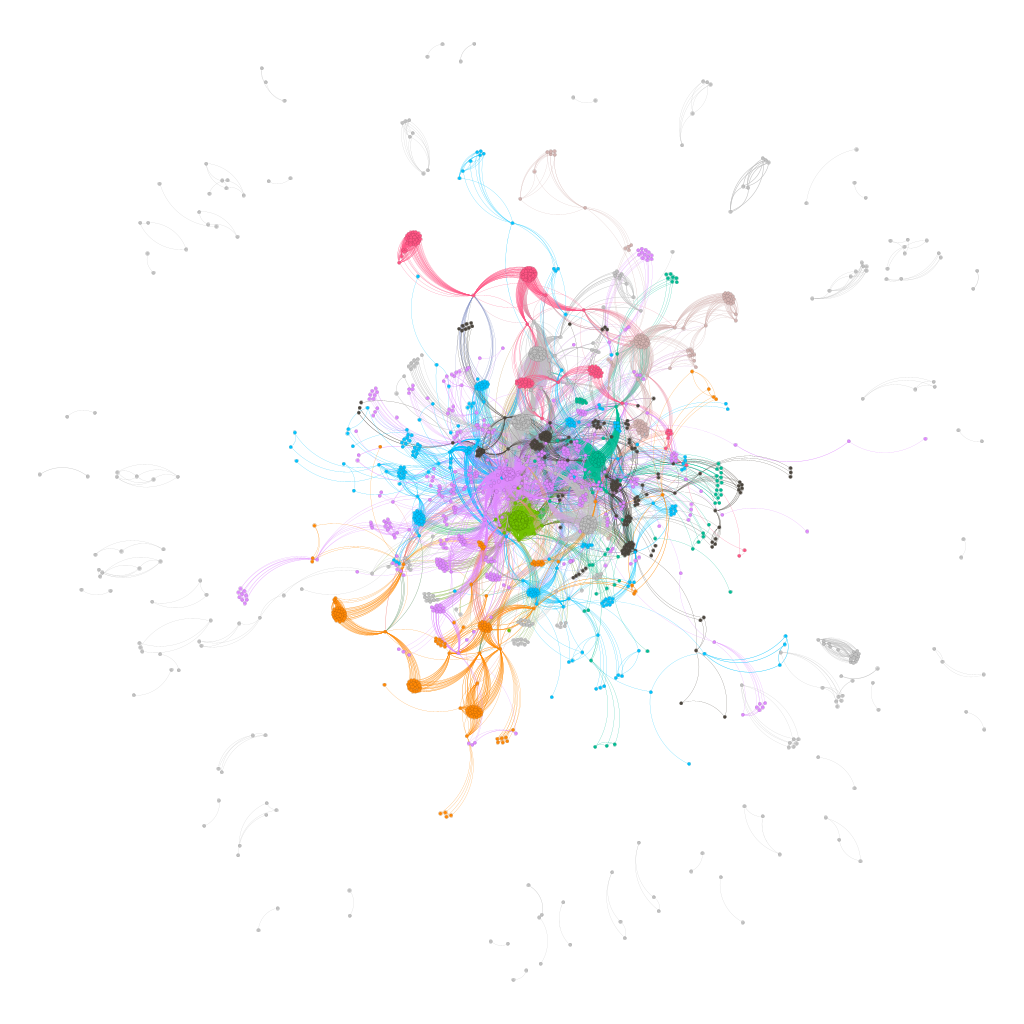

In [57]:
# Display the network communities visualization exported from Gephi
Image(filename='images/yelp_network_communities.png')

## Community Summary and Visualization for Louvain Communities

The **top 10 identified** communities were summarized by:

- **Community size** and **average user review characteristics**  
- **Common nouns, adjectives, preferred categories, neighbourhoods, and tags**  
- **Bar plots** visualized distributions of **categories**, **neighbourhoods**, and **tags** across top communities

This provided profiles highlighting **community-specific user preferences and behaviors**.

In [58]:
# Convert node attributes dictionary to DataFrame
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').reset_index()
df_nodes.rename(columns={'index': 'node'}, inplace=True)

df_nodes['community'] = df_nodes['community'].astype(str)

In [59]:
# Function to summarize attributes for top Louvain communities
def summarize_communities(df, community_list, community_col='community'):
    summary_list = []

    for com in community_list:
        community_nodes = df[df[community_col] == com]

        mean_n_unique_restaurants = community_nodes['n_unique_restaurants'].mean()
        mean_avg_review_length = community_nodes['avg_review_length'].mean()
        mean_avg_n_reviews = community_nodes['avg_n_reviews'].mean()

        top_noun = community_nodes['most_common_noun'].mode().iloc[0]
        top_adjective = community_nodes['most_common_adjective'].mode().iloc[0]
        top_category = community_nodes['preferred_category'].mode().iloc[0]
        top_neighbourhood = community_nodes['preferred_neighbourhood'].mode().iloc[0]
        top_tag = community_nodes['preferred_tag'].mode().iloc[0]

        print(f"\n--- Community {com} ---")
        print(f"Community size: {len(community_nodes)}")
        print(f"Mean unique restaurants: {mean_n_unique_restaurants:.2f}")
        print(f"Mean average review length: {mean_avg_review_length:.2f}")
        print(f"Top noun: {top_noun}")
        print(f"Top adjective: {top_adjective}")
        print(f"Top category: {top_category}")
        print(f"Top neighbourhood: {top_neighbourhood}")
        print(f"Mean average n_reviews: {mean_avg_n_reviews:.2f}")
        print(f"Top tag: {top_tag}")

        summary_list.append({
            community_col: com,
            f'{community_col}_size': len(community_nodes),
            'mean_n_unique_restaurants': mean_n_unique_restaurants,
            'mean_avg_review_length': mean_avg_review_length,
            'top_noun': top_noun,
            'top_adjective': top_adjective,
            'top_category': top_category,
            'top_neighbourhood': top_neighbourhood,
            'mean_avg_n_reviews': mean_avg_n_reviews,
            'top_tag': top_tag
        })

    return pd.DataFrame(summary_list)

In [60]:
# Summarize attributes for top 3 communities
top_n = 3
top_communities = df_nodes['community'].value_counts().head(top_n).index.tolist()

summary_df = summarize_communities(df=df_nodes, community_list=top_communities)


--- Community 4 ---
Community size: 441
Mean unique restaurants: 1.73
Mean average review length: 38.73
Top noun: food
Top adjective: good
Top category: Breakfast & Brunch
Top neighbourhood: Stazione Centrale
Mean average n_reviews: 18.40
Top tag: pastry

--- Community 73 ---
Community size: 325
Mean unique restaurants: 1.47
Mean average review length: 38.85
Top noun: food
Top adjective: good
Top category: Italian
Top neighbourhood: Centro Storico
Mean average n_reviews: 12.56
Top tag: pizza

--- Community 5 ---
Community size: 242
Mean unique restaurants: 2.12
Mean average review length: 42.44
Top noun: food
Top adjective: good
Top category: Barbeque
Top neighbourhood: Palestro
Mean average n_reviews: 198.11
Top tag: pasta


In [61]:
# Function to plot top categories (or other attributes) per community
def plot_top_k_per_community(df, 
                             community_col='community',
                             category_col='preferred_category',
                             top_k_communities=10,
                             top_k_categories=10,
                             title=None,
                             colormap='tab10'):
    
    # Get top k values
    top_communities = df[community_col].value_counts().head(top_k_communities).index
    top_categories = df[category_col].value_counts().head(top_k_categories).index

    # Filter the DataFrame
    df_filtered = df[
        (df[community_col].isin(top_communities)) & 
        (df[category_col].isin(top_categories))
        ]

    # Cross-tabulate
    counts = pd.crosstab(df_filtered[community_col], df_filtered[category_col])

    # Sort communities for visual consistency
    community_sizes = df[community_col].value_counts().loc[top_communities]
    counts = counts.loc[community_sizes.loc[counts.index].sort_values(ascending=False).index]

    numeric_labels = range(1, len(counts.index) + 1)

    # Plot
    plt.figure(figsize=(12, 7))
    counts.plot(kind='bar', stacked=False, colormap=colormap, ax=plt.gca())

    if not title:
        title = f'Top {top_k_categories} {category_col.replace("_", " ").title()} per Top {top_k_communities} Communities'
    
    plt.title(title)
    plt.xlabel('Community')
    plt.ylabel('Number of Users')
    plt.legend(title=category_col.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(ticks=range(len(numeric_labels)), labels=numeric_labels, rotation=0)
    plt.tight_layout()
    plt.show()

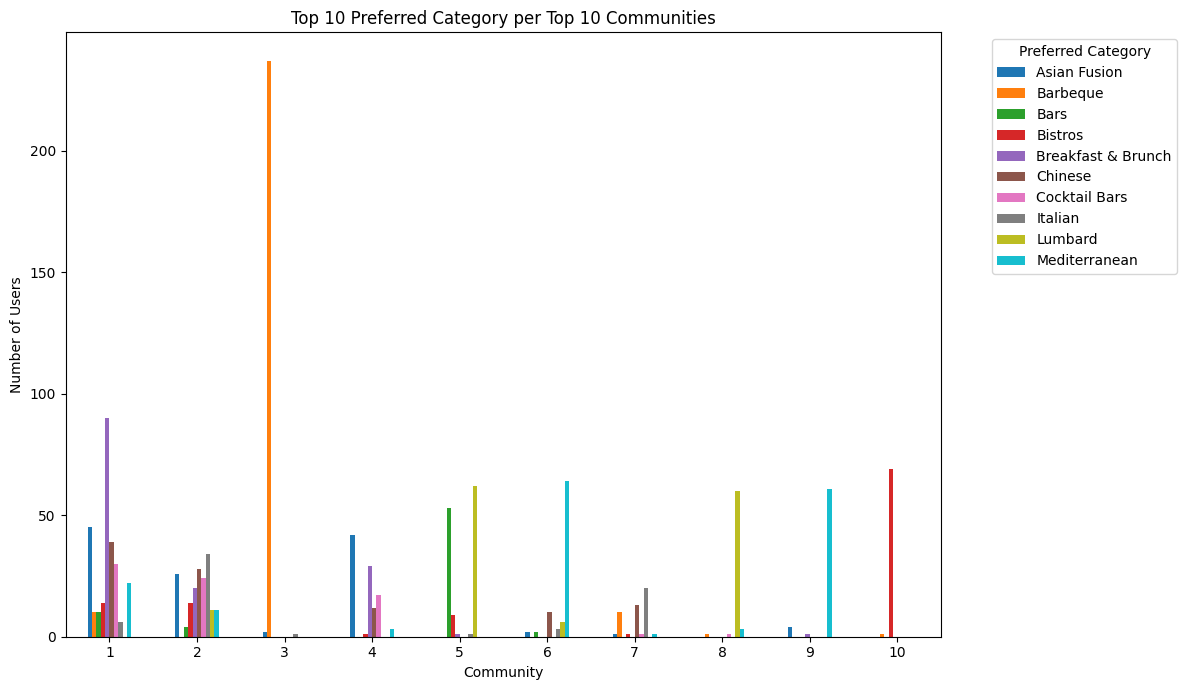

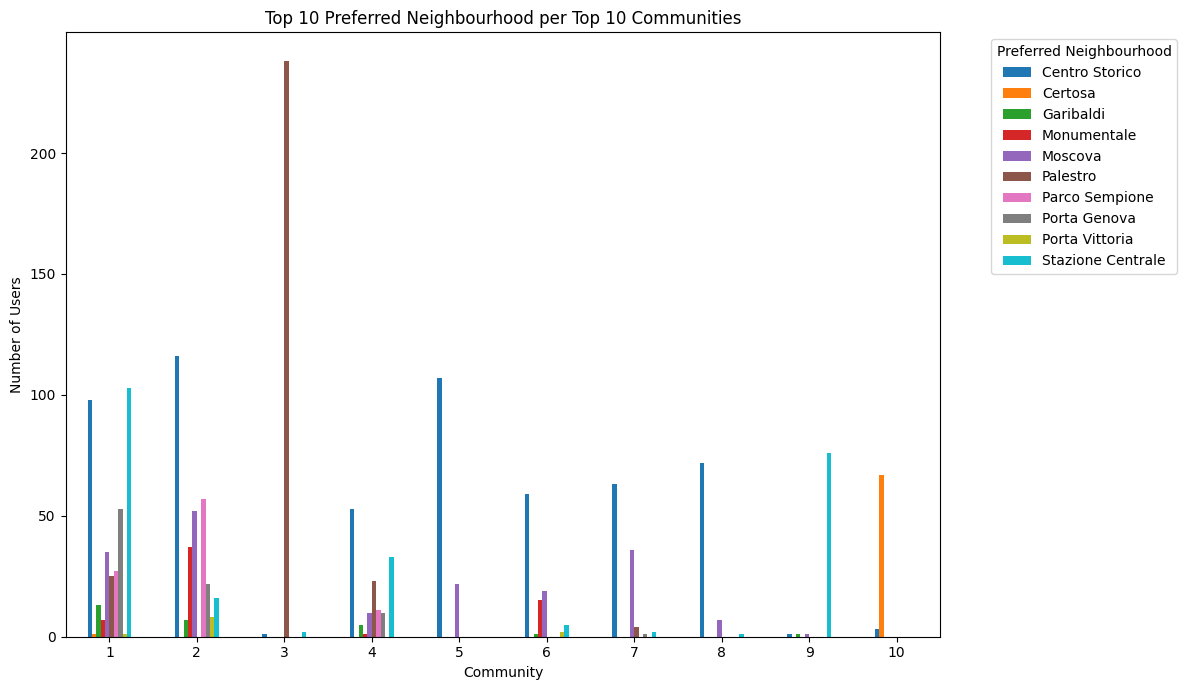

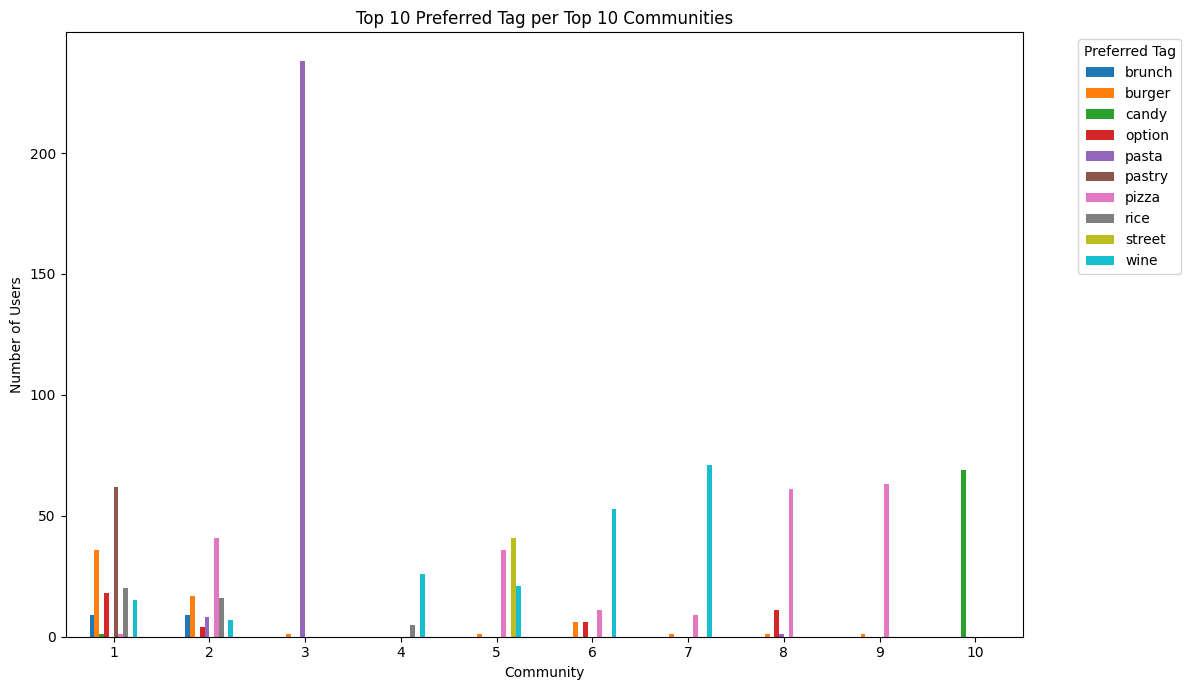

In [62]:
plot_top_k_per_community(df_nodes, category_col='preferred_category')
plot_top_k_per_community(df_nodes, category_col='preferred_neighbourhood')
plot_top_k_per_community(df_nodes, category_col='preferred_tag')

## Comment

It can be seen that while **preferred category** and **neighbourhood** are quite informative for characterizing communities, **tags** do not provide meaningful differentiation and will therefore be ignored in further analysis.

Analyzing the **top 10 communities** by size, the following dominant preferences can be distinguished:

1. **International cuisines** and **regional Italian cuisines (excluding Lombardia)** -- focus on **breakfast/brunch** spots -- spread across neighbourhoods, but concentrated in **Stazione Centrale**, **Centro Storico**, and **Porta Genova** - popular dining districts in Milan.

2. A **mixed selection** of categories, **excluding barbeque** -- dominant in **Centro Storico**, avoiding Certosa and Palestro.

3. Strong preference for **barbeque** -- centered in **Palestro**.

4. **Asian fusion**, **brunch**, and **cocktail bars** -- concentrated in **Centro Storico**, **Stazione Centrale**, and **Palestro**.

5. **Lombardian cuisine** and **bars** -- localized in **Centro Storico**.

6. Focus on **Mediterranean cuisine** -- mainly **Centro Storico**.

7. Combination of **Italian**, **Chinese**, and **barbeque cuisines** -- popular in **Centro Storico** and **Moscova**.

8. **Lombardian cuisine** again -- dominant in **Centro Storico** and **Moscova**.

9. **Mediterranean cuisine** with preference for **Stazione Centrale**.

10. **Mediterranean cuisine**, but primarily in **Certosa**.

Notably, **Centro Storico** appears across most communities, which is expected due to its size and its role as a **central, restaurant-dense area of Milan**.

## Subgraph Analysis and Sub-Community Profiling

A selected **Louvain community** was analyzed in detail by:

- Extracting its **subgraph**  
- Identifying **top users** by **unique restaurants reviewed**  
- Detecting **sub-communities** within via **Louvain**  
- Computing **summary statistics** per sub-community  
- Visualizing **preferences** with **bar plots** for **categories, neighbourhoods, and tags**

In [63]:
# Choose target community to analyze further
target_community = df_nodes['community'].value_counts().idxmax()

# Get nodes belonging to this community
community_nodes = df_nodes[df_nodes['community'] == target_community]['node'].tolist()

# Extract subgraph
G_sub = G.subgraph(community_nodes).copy()

print(f"Nodes in community {target_community}: {G_sub.number_of_nodes()}")
print(f"Edges in community {target_community}: {G_sub.number_of_edges()}")

Nodes in community 4: 441
Edges in community 4: 4552


In [64]:
# Louvain on subgraph
sub_louvain_partition = community_louvain.best_partition(G_sub, random_state=42)

sub_louvain_n_communities = len(set(sub_louvain_partition.values()))
print(f"Number of communities: {sub_louvain_n_communities}")

Number of communities: 13


In [65]:
sub_louvain_community_sizes = Counter(sub_louvain_partition.values())

print("Number of users per community:")
for community_id, size in sub_louvain_community_sizes.items():
    print(f"Community {community_id}: {size} users")

Number of users per community:
Community 0: 20 users
Community 1: 54 users
Community 2: 35 users
Community 3: 74 users
Community 4: 46 users
Community 5: 85 users
Community 7: 26 users
Community 8: 8 users
Community 9: 3 users
Community 12: 75 users
Community 10: 9 users
Community 11: 4 users
Community 6: 2 users


## Comment

The **largest community** was analyzed in more detail, as it **spans a wide variety of cuisines, categories, and neighbourhoods**, suggesting the presence of meaningful internal structure. Applying the **Louvain method** within this community revealed **13 subcommunities**, with **user counts ranging from 2 to 73**.

In [66]:
# Update node attributes with subgraph partition
nx.set_node_attributes(G_sub, sub_louvain_partition, 'community')

In [67]:
# Save the subgraph for visualization
nx.write_gexf(G_sub, "graphs/yelp_subnetwork.gexf")

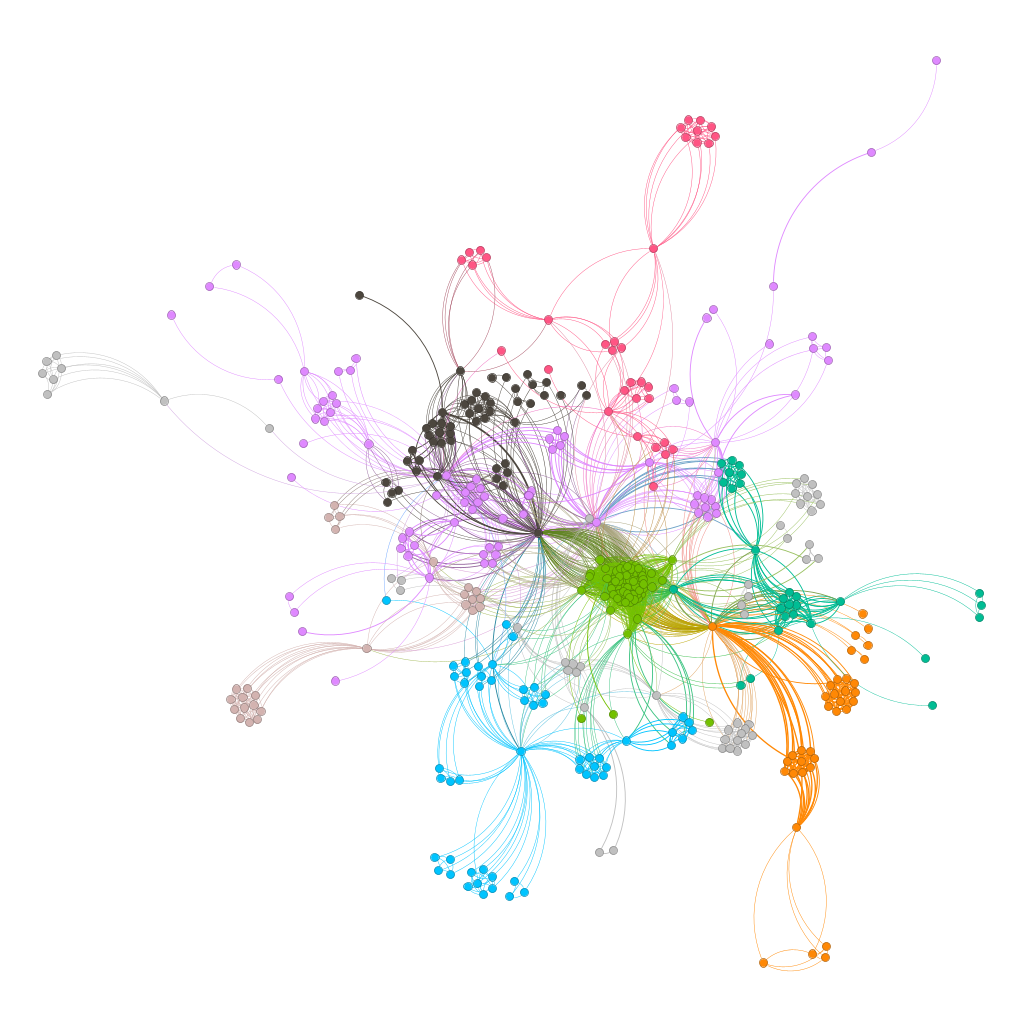

In [68]:
# Display the subnetwork communities visualization exported from Gephi
Image(filename='images/yelp_subnetwork_communities.png')

In [69]:
# Prepare DataFrame and summarize subgraph communities
sub_df_nodes = pd.DataFrame.from_dict(dict(G_sub.nodes(data=True)), orient='index').reset_index()
sub_df_nodes.rename(columns={'index': 'node'}, inplace=True)
sub_df_nodes['community'] = sub_df_nodes['community'].astype(str)

# List of communities detected in subgraph
communities = sub_df_nodes['community'].unique()

sub_summary_df = summarize_communities(df=df_nodes, community_list=communities)


--- Community 0 ---
Community size: 19
Mean unique restaurants: 1.16
Mean average review length: 35.32
Top noun: food
Top adjective: excellent
Top category: Italian
Top neighbourhood: Centro Storico
Mean average n_reviews: 8.87
Top tag: waiter

--- Community 1 ---
Community size: 79
Mean unique restaurants: 2.00
Mean average review length: 38.16
Top noun: food
Top adjective: good
Top category: Mediterranean
Top neighbourhood: Stazione Centrale
Mean average n_reviews: 50.91
Top tag: pizza

--- Community 2 ---
Community size: 5
Mean unique restaurants: 1.00
Mean average review length: 114.20
Top noun: course
Top adjective: beautiful
Top category: Breakfast & Brunch
Top neighbourhood: Porta Genova
Mean average n_reviews: 5.00
Top tag: lunch

--- Community 3 ---
Community size: 2
Mean unique restaurants: 1.00
Mean average review length: 27.50
Top noun: food
Top adjective: elegant
Top category: Mediterranean
Top neighbourhood: Centro Storico
Mean average n_reviews: 2.00
Top tag: pleasure



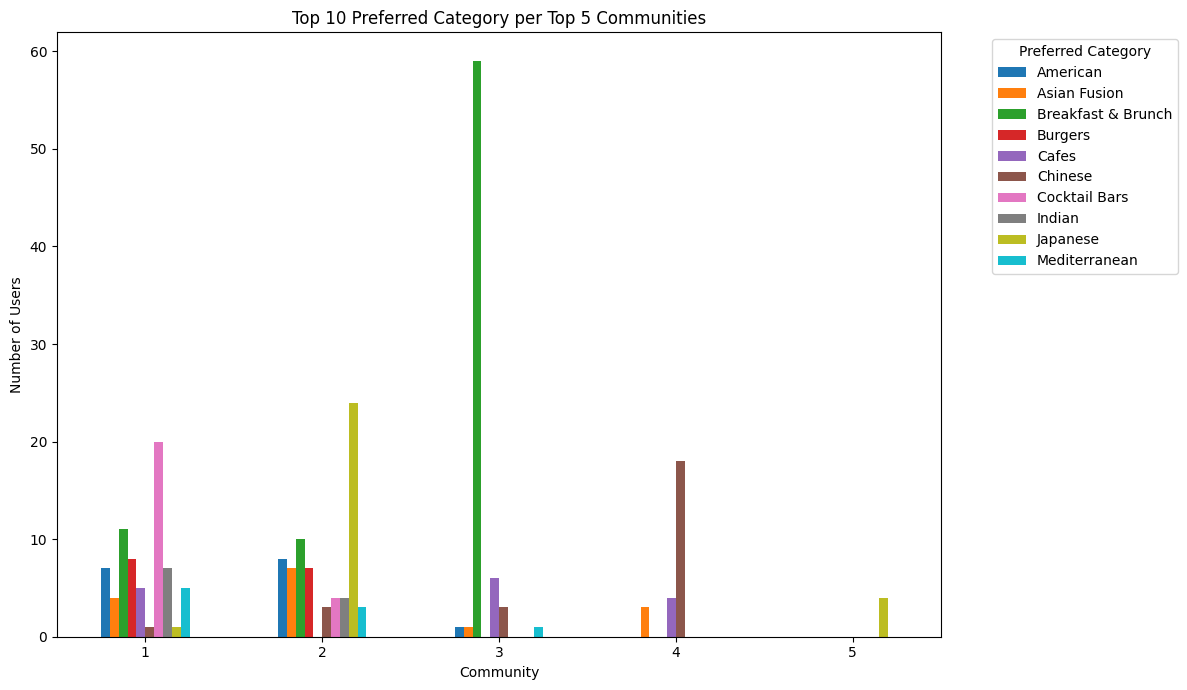

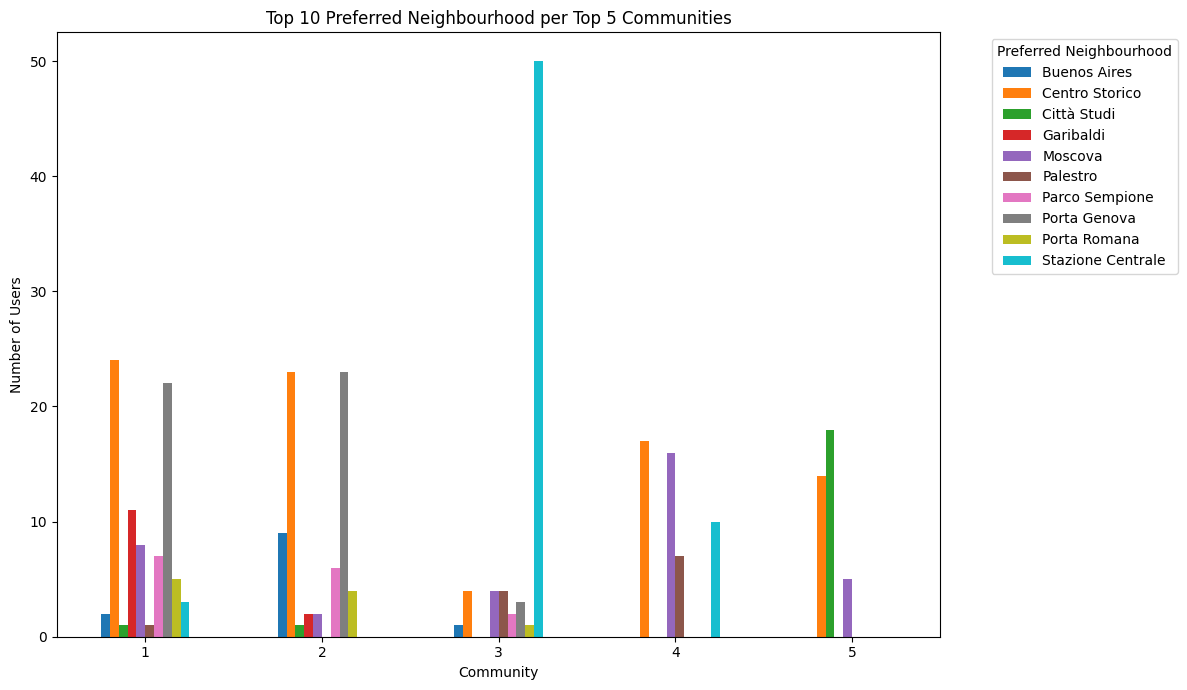

In [70]:
plot_top_k_per_community(sub_df_nodes, category_col='preferred_category', top_k_communities=5)
plot_top_k_per_community(sub_df_nodes, category_col='preferred_neighbourhood', top_k_communities=5)

## Comment

Focusing on the **top 5 largest subcommunities** within the largest community, the following dominant patterns emerged:

1. **Breakfast** and **brunch** preferences, concentrated in **Stazione Centrale**.

2. **Mixed cuisine preferences** with a notable absence of cafes and a **prevalence of Japanese cuisine** -- mainly found in **Centro Storico** and **Porta Genova**.

3. Focus on **cocktail bars**, accompanied by a variety of other categories -- users are spread across neighbourhoods, especially **Porta Genova**.

4. Strong preference for **Chinese cuisine**, centered in **Centro Storico**, **Moscova**, and **Stazione Centrale**.

5. Preference for **Japanese cuisine**, mainly located in **Città Studi** and **Centro Storico**.

## Similarity-Based Collaborative Filtering and Personalized Recommendations

A variation of **user-based collaborative filtering** was implemented where the basic condition for similarity is whether **two users are connected**. This can be enhanced by incorporating **edge weight** (i.e., number of shared restaurants) and additional **node attributes**, resulting in a composite **similarity score** between users.

Three **recommendation types** are supported (`recommend_type`):

1. `restaurant` - specific restaurant suggestions  
2. `category` - most frequently liked restaurant categories  
3. `neighbourhood` - most frequently liked neighbourhoods

The **recommendation algorithm** proceeds as follows:

1. Select a **target user**.
2. Identify the user’s **neighbours**:
   - Either **all** graph neighbours, or
   - Only those **within the same community** (`restrict_to_community=True`)
3. Collect **reviews** written by these neighbours.
4. Filter the reviews based on a **minimum rating threshold** (`rating_threshold`).
5. Generate recommendations depending on the selected `recommend_type`:
   - For `restaurant`:
     - Rank restaurants by **how many neighbours** liked them, or
     - By the **sum of similarity scores from neighbours** who liked them (`use_similarity_scores=True`).
   - For `category` and `neighbourhood`:  
     - Return the **most frequently liked categories** or **neighbourhoods** among neighbours (no additional ranking needed).

In [71]:
# Function to compute similarity between two users
def compute_user_similarity(user_a, user_b):
    sim_score = G[user_a][user_b].get('weight', 0)

    def attr_similarity(attr, type='numeric'):
        a = nx.get_node_attributes(G, attr)[user_a]
        b = nx.get_node_attributes(G, attr)[user_b]
        if type == 'numeric':
            return 1 - abs(a - b) / max(a, b, 1)
        return 1 if a == b else 0

    sim_score += attr_similarity('n_unique_restaurants')
    sim_score += attr_similarity('avg_review_length')
    sim_score += attr_similarity('most_common_noun', type='categorical')
    sim_score += attr_similarity('most_common_adjective', type='categorical')
    sim_score += attr_similarity('preferred_category', type='categorical')
    sim_score += attr_similarity('preferred_neighbourhood', type='categorical')
    sim_score += attr_similarity('avg_n_reviews')
    sim_score += attr_similarity('preferred_tag', type='categorical')

    return sim_score

In [72]:
# Function to provide restaurant, category, or neighborhood recommendations
def recommend_by_similar_users(
    user_id,
    G,
    df_reviews,
    df_restaurants,
    recommend_type='restaurant',  # 'restaurant', 'category', or 'neighbourhood'
    restrict_to_community=False,
    community_attr='community',
    rating_threshold=4.0,
    use_similarity_scores=False,
    top_n=5,
    restaurant_id_col='url',
    restaurant_name_col='name',
    restaurant_category_col='categories',
    restaurant_neighbourhood_col='neighbourhood',
    user_id_col='user_id'
):
    
    if user_id not in G:
        print(f"User {user_id} not found in graph.")
        return
    
    neighbours = list(G.neighbors(user_id))
    if restrict_to_community:
        user_comm = G.nodes[user_id][community_attr]
        neighbours = [n for n in neighbours if G.nodes[n].get(community_attr) == user_comm]

    if not neighbours:
        print("No neighbours found (with the current filtering).")
        return
    
    
    similarity_scores = {
        neighbor: compute_user_similarity(user_id, neighbor)
        for neighbor in neighbours
    }

    liked = df_reviews[
        (df_reviews[user_id_col].isin(neighbours)) &
        (df_reviews['rating'] >= rating_threshold)
    ]

    visited = set(df_reviews[df_reviews[user_id_col] == user_id][restaurant_id_col])
    liked = liked[~liked[restaurant_id_col].isin(visited)]

    if liked.empty:
        print("No new restaurants to recommend from neighbours.")
        return
    
    liked = liked[[user_id_col, restaurant_id_col, 'rating']]
    liked['similarity_score'] = liked[user_id_col].map(similarity_scores)

    recs = (
        liked.groupby(restaurant_id_col)
        .agg(
            avg_rating=('rating', 'mean'),
            n_neighbours=('rating', 'count'),
            total_similarity_score=('similarity_score', 'sum')
        )
        .reset_index()
    )
    
    df_restaurants = df_restaurants[[
        restaurant_id_col,
        restaurant_name_col,
        restaurant_category_col,
        restaurant_neighbourhood_col
        ]].drop_duplicates()
    recs = recs.merge(df_restaurants, on=restaurant_id_col, how='left')\
        .drop(restaurant_id_col, axis=1).drop_duplicates()

    if recommend_type == 'restaurant':
        if use_similarity_scores:
            top_recs = recs.sort_values(by=['total_similarity_score', 'avg_rating'], ascending=[False, False])\
                .drop_duplicates(subset=['name']).head(5)
        else:
            top_recs = recs.sort_values(by=['n_neighbours', 'avg_rating'], ascending=[False, False])\
                .drop_duplicates(subset=['name']).head(5)
                
    elif recommend_type == 'category':
        top_recs = recs['categories'].value_counts().head(5)
    
    elif recommend_type == 'neighbourhood':
        top_recs = recs['neighbourhood'].value_counts().head(5)
        
    else:
        print(f"Unknown recommend_type '{recommend_type}'. Choose from 'restaurant', 'category', 'neighbourhood'.")
        return

    if recommend_type == 'restaurant':
        sort_method = "sum of similarity scores" if use_similarity_scores else "number of neighbours"
        community_str = "neighbours within community" if restrict_to_community else "all neighbours"
        print(f"\nTop {top_n} {recommend_type} recommendations for user {user_id} (from {community_str}; sorted by {sort_method}):")
        for _, row in top_recs.iterrows():
            print(f"- {row.get(restaurant_name_col)} "
                  f"(Neighbourhood: {row.get(restaurant_neighbourhood_col)}, Avg rating: {row['avg_rating']:.2f})")

    else:
        community_str = "neighbours within community" if restrict_to_community else "all neighbours"
        print(f"\nTop {top_n} {recommend_type} recommendations for user {user_id} (from {community_str}):")
        for item, count in top_recs.items():
            print(f"- {item} ({count} neighbours)")

In [73]:
target_user='Qe7dwOKdAI_J6Z4XmupOvw'

# Recommend categories (within community)
recommend_by_similar_users(
    user_id=target_user,
    G=G,
    df_reviews=df_reviews,
    df_restaurants=df_restaurants,
    recommend_type='category',
    restrict_to_community=True,
    rating_threshold=4.2,
    top_n=5
)

# Recommend restaurants (within community, sorted by similarity)
recommend_by_similar_users(
    user_id=target_user,
    G=G,
    df_reviews=df_reviews,
    df_restaurants=df_restaurants,
    recommend_type='restaurant',
    restrict_to_community=True,
    rating_threshold=4.1,
    use_similarity_scores=True,
    top_n=5
)

# Recommend neighbourhoods (across all users)
recommend_by_similar_users(
    user_id=target_user,
    G=G,
    df_reviews=df_reviews,
    df_restaurants=df_restaurants,
    recommend_type='neighbourhood',
    rating_threshold=3.8,
    top_n=5
)


Top 5 category recommendations for user Qe7dwOKdAI_J6Z4XmupOvw (from neighbours within community):
- Mediterranean (7 neighbours)
- Japanese (6 neighbours)
- Cocktail Bars (5 neighbours)
- Brazilian (4 neighbours)
- Cafes (3 neighbours)

Top 5 restaurant recommendations for user Qe7dwOKdAI_J6Z4XmupOvw (from neighbours within community; sorted by sum of similarity scores):
- Maya (Neighbourhood: Porta Genova, Avg rating: 5.00)
- Taj Mahal (Neighbourhood: Garibaldi, Avg rating: 5.00)
- Pizzeria di Porta Garibaldi (Neighbourhood: Moscova, Avg rating: 5.00)
- Yazawa (Neighbourhood: Moscova, Avg rating: 5.00)
- Nùn (Neighbourhood: Buenos Aires, Avg rating: 5.00)

Top 5 neighbourhood recommendations for user Qe7dwOKdAI_J6Z4XmupOvw (from all neighbours):
- Centro Storico (40 neighbours)
- Moscova (31 neighbours)
- Porta Genova (26 neighbours)
- Palestro (18 neighbours)
- Porta Romana (15 neighbours)
